<a href="https://colab.research.google.com/github/rss2022-2/final_challenge_2022/blob/main/TrainingNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# TODO: Change below
path_to_dir = '/content/gdrive/MyDrive/final-challenge-ml-folder'

import sys
sys.path.append(path_to_dir)

In [ ]:
from __utils__ import *
import scipy.ndimage.morphology
import torch.nn.functional as F
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import argparse
import os
from tqdm import tqdm, trange
import cv2
from IPython.display import Image, display_png, clear_output
import torchvision
import torchvision.transforms as transforms

In [ ]:
# TODO: Set the height and width of the (feel free to change)
H, W = 26, 30

# Define path to image and result directories
path_to_img_dir = os.path.join(path_to_dir, "images")
path_to_res_dir = os.path.join(path_to_dir, "results")

class RoadDataset(torch.utils.data.Dataset):
    def __init__(self, patches, labels):
        self.patch_tensors = patches
        self.patch_labels = labels
        tf = nn.Sequential(
            transforms.RandomVerticalFlip(.1),
            transforms.RandomHorizontalFlip(.5),
            #transforms.RandomRotation(90)
        )
        self.transforms = torch.jit.script(tf)

    def __getitem__(self, index):
        img = self.patch_tensors[index] #self.transforms(self.patch_tensors[index]) # Feel free to enable, may slow training time though
        return img, self.patch_labels[index]

    def __len__(self):
        return len(self.patch_tensors)

def create_datasets(img_dir, res_dir, device = "cuda", y_cutoff = 170, train_fraction = 0.8, frac_road = .5):
    patch_tensors = []
    patch_labels = []
    for mask_name in tqdm(os.listdir(res_dir)):
        add_img = True
        try:
            img_name = mask_name.split(".")[0] + ".png"
            img_path = os.path.join(img_dir, img_name)
            mask_path = os.path.join(res_dir, mask_name)

            # Split each img into patches of size (H, W)
            # Each patches tensor has the shape:
            # [num_h, num_w, 3, H, W]
            # where num_h/w is the number of patches along each dimension
            img = open_img_as_tensor(img_path)
            img = img[:, y_cutoff:]
            mask = np.load(mask_path)[y_cutoff:]
            
            
        except:
            add_img = False

        if add_img:
            shape = img.shape
            num_samples = int(3 * img.shape[1] * img.shape[2] // (H * W))
            hs = np.random.randint(0, shape[1] - H, num_samples)
            ws = np.random.randint(0, shape[2] - W, num_samples)
            
            pths = []
            ms = []

            for h_, w_ in zip(hs, ws):
                patch = img[:, h_: h_+H, w_: w_+W]
                m = np.mean(mask[h_: h_+H, w_: w_+W]) >= frac_road
                pths.append(patch.reshape(1, -1, H, W))
                ms.append(m)

            pths = torch.cat(pths)
            ms = torch.tensor(ms)

            patch_tensors.append(pths)
            patch_labels.append(ms.reshape(-1))

    
    patch_tensors = torch.cat(patch_tensors)
    patch_labels = torch.cat(patch_labels).type(torch.LongTensor)

    print(patch_tensors.shape)
    print(patch_labels.shape)

    assert len(patch_tensors) == len(patch_labels)
    shuffle = torch.randperm(len(patch_tensors))

    patch_labels, patch_tensors = patch_labels[shuffle].to(device), patch_tensors[shuffle].to(device)
    
    train_len = int(train_fraction * len(patch_tensors))

    train_set = RoadDataset(patch_tensors[:train_len], patch_labels[:train_len])
    val_set = RoadDataset(patch_tensors[train_len:], patch_labels[train_len:])

    print("Train Set Size:", len(train_set))
    print("Val Set Size:", len(val_set))

    return train_set, val_set

In [ ]:
class RoadDetectorNet(nn.Module):
    def __init__(self):
        super(RoadDetectorNet, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 16, 5),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, 5),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, 3),
        )
        self.fc = nn.Sequential(nn.Linear(16 * (H - 10) * (W - 10), 16), nn.ReLU(inplace=True),
                                nn.Linear(16, 2))

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [ ]:
# TODO: Hyperparameters (feel free to change)
batch_size = 512
train_fraction = 0.75
checkpoint_path = os.path.join(path_to_dir, "checkpoints")
y_cutoff = 100
checkpoint_freq = 5
frac_road = .6

# Set number of training epochs
EPOCHS = 100

device = "cuda"

In [ ]:
img_names = []
for file in os.listdir(path_to_img_dir):
    file_name = file.split(".")[0]
    img_names.append(file_name)

annotation_names = []
for file in os.listdir(path_to_res_dir):
    file_name = file.split(".")[0]
    annotation_names.append(file_name)

"""for img in img_names:
    assert img in annotation_names"""

# for annot in annotation_names:
#     assert annot in img_names

train_set, val_set = create_datasets(path_to_img_dir, path_to_res_dir, device = device, y_cutoff = y_cutoff, train_fraction = train_fraction, frac_road=frac_road)

100%|██████████| 28/28 [00:40<00:00,  1.43s/it]


torch.Size([19251, 3, 26, 30])
torch.Size([19251])
Train Set Size: 14438
Val Set Size: 4813


In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
print("Train Loader Size:", len(train_loader))
print("Val Loader Size:", len(val_loader))

Train Loader Size: 29
Val Loader Size: 10


In [ ]:
if train_fraction / (1 - train_fraction) > 1.5:
    weight_decay = 0.001
elif train_fraction / (1 - train_fraction) < 1.1:
    weight_decay = 0.00003
else:
    weight_decay = 0.0005

print(weight_decay)

model = RoadDetectorNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)
loss_fxn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=.99)

0.001


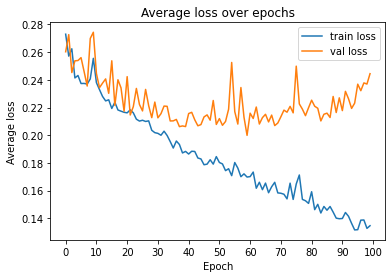

    0.1337: 100%|██████████| 100/100 [02:16<00:00,  1.36s/it]


In [ ]:
losses = []
val_losses = []
checkpoint_names = []

with trange(EPOCHS) as pbar:
    for i in pbar:
        epoch_loss = []
        epoch_val_loss = []
        
        for batch_idx, (train_features, train_labels) in enumerate(train_loader):
            optimizer.zero_grad()
            pred = model(train_features)
            loss = loss_fxn(pred, train_labels)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            if batch_idx % 10 == 0:
                pbar.set_description(f'{np.mean(np.array(epoch_loss)):6.4}'.rjust(10))    
        
        for batch_idx, (val_features, val_labels) in enumerate(val_loader):
            with torch.no_grad():
                pred = model(val_features)
                loss = loss_fxn(pred, val_labels)
                epoch_val_loss.append(loss.item())

        scheduler.step()
        losses.append(torch.mean(torch.tensor(epoch_loss)))
        val_losses.append(torch.mean(torch.tensor(epoch_val_loss)))
        
        l, vl = losses[-1], val_losses[-1]
        if i % checkpoint_freq == 0:
            checkpoint = os.path.join(checkpoint_path, "weights_l" + f'{l:6.4}' + "_vl" + f'{vl:6.4}' + ".pth")
            torch.save(model, checkpoint)
            checkpoint_names.append(checkpoint)

        clear_output(wait=True)
        plt.plot(range(len(losses)), losses, label='train loss')
        plt.plot(range(len(val_losses)), val_losses, label='val loss')
        plt.legend()
        plt.title("Average loss over epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.xticks(range(0, EPOCHS + 1, EPOCHS // 10))
        plt.show()

In [ ]:
lowest_val = np.argmin(val_losses[::checkpoint_freq])
model = torch.load(checkpoint_names[lowest_val])
print(checkpoint_names[lowest_val])

def visualize_mask(image, mask, dims, ax = None):
    img_H, img_W = image.shape[0], image.shape[1]
    H, W = dims
    assert mask.shape[0] == img_H // H and mask.shape[1] == img_W // W
    
    vis_mask = np.zeros([img_H, img_W], np.uint16)

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j] == 1:
                vis_mask[i*H:(i+1)*H, j*W:(j+1)*W] = 1
    
    if ax is not None:
        ax.imshow(image)
        ax.imshow(vis_mask, alpha = 0.25)
    else:
        plt.imshow(image)
        plt.imshow(vis_mask, alpha = 0.25)

/content/gdrive/MyDrive/final-challenge-ml-folder/checkpoints/weights_l0.1908_vl0.2104.pth


In [ ]:
mask_img_list = []
sm = torch.nn.Softmax(dim=2)
path_to_test = "/content/gdrive/MyDrive/final-challenge-ml-folder/testimages"
for img_name in os.listdir(path_to_test): #[::len(os.listdir(path_to_test)) // 25][:25]:
    img_path = os.path.join(path_to_test, img_name)
    img = open_img_as_tensor(img_path)
    cutoff_img = img[:, y_cutoff:]
    split = split_img(cutoff_img, (H, W)).to(device)
    output = model(split.reshape([-1, 3, H, W])).reshape([split.shape[0], split.shape[1], 2])
    #mask = torch.argmax(output, dim=-1)
    sm_output = sm(output)
    #print(sm_output)
    mask = sm_output[:, :, 1] > .5
    full_mask = torch.zeros([img.shape[1] // H, img.shape[2] // W])
    full_mask[-mask.shape[0]:] = mask
    np_img = np.array(img.to("cpu")).transpose(1, 2, 0)
    mask_img_list.append((full_mask, np_img))

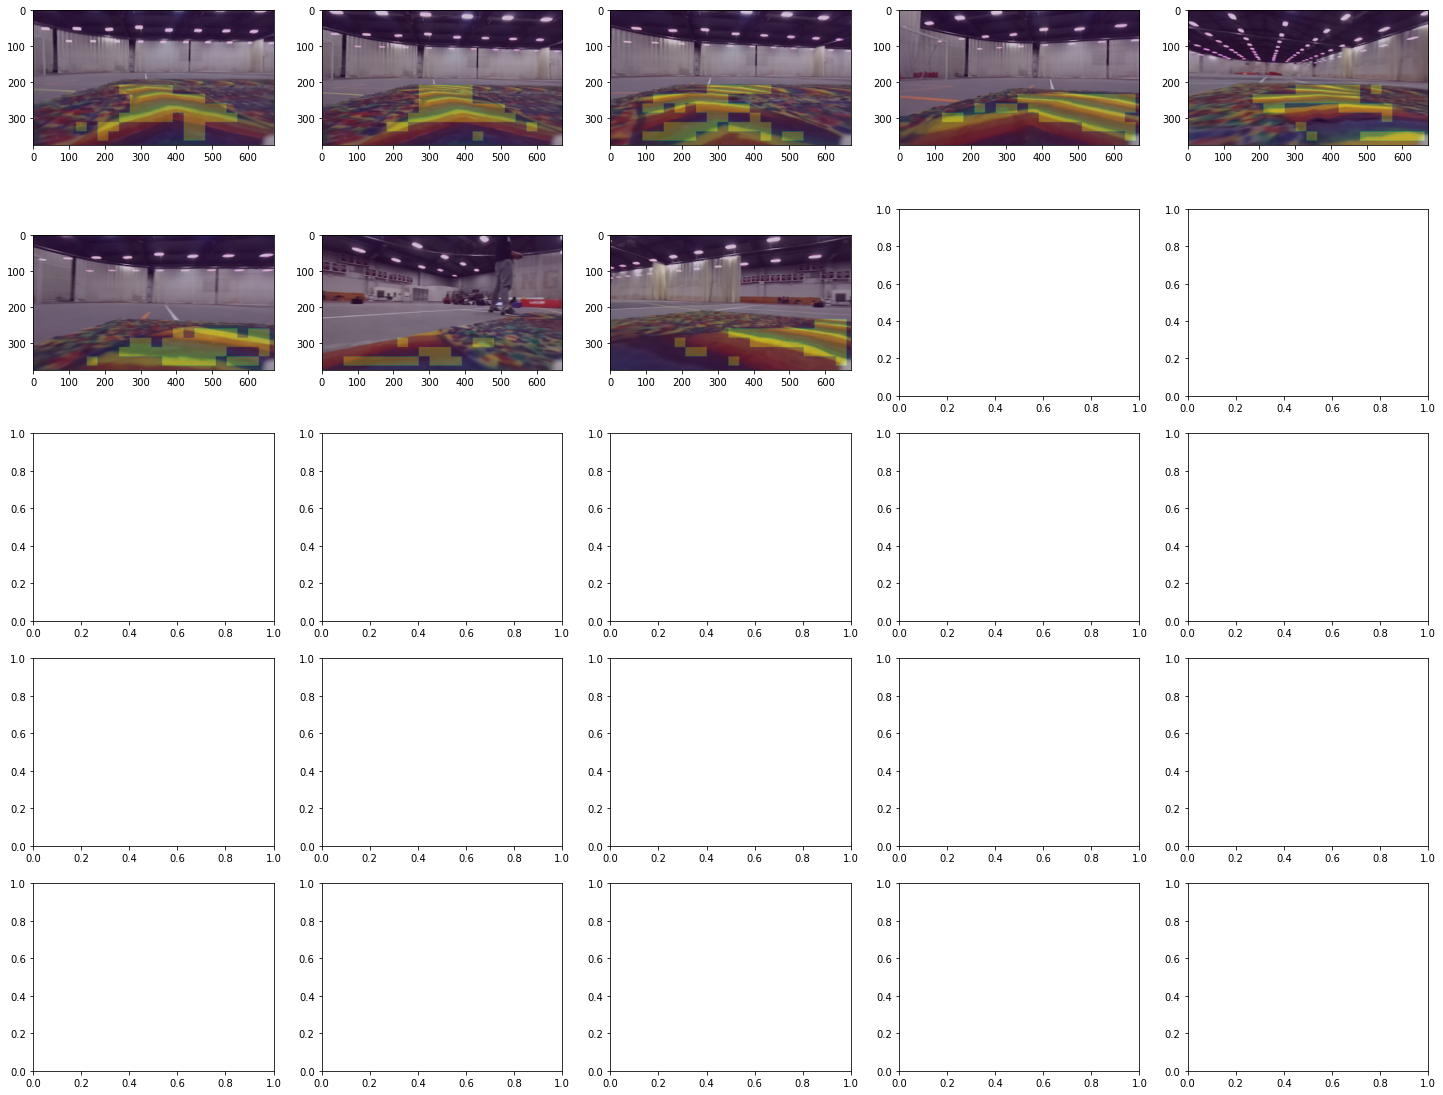

In [ ]:
scale = 5
fig, axs = plt.subplots(5, 5, figsize=(5*scale, 4*scale))
for idx, (m, i) in enumerate(mask_img_list):
    visualize_mask(i, m, (H,W), axs[idx // 5, idx % 5])
    #axs[idx // 6, idx % 6].imshow(m.cpu().detach().numpy())